# Speed dating data-set
## Discrimination-aware classification
#### <i>Abdel K. Bokharouss, Bart van Helvert, Joris Rombouts & Remco Surtel</i>   -   December 2017

<font color="darkred"><b><i>Important note: a concrete goal of this assignment is, among other things, to give an extensive and qualitative comparison between a model which includes sensitive attributes and a model which excludes these sensitive attributes. Whether or not attributes are considered to be sensitive is subjective, and any decisions should, therefore, be supported by well-grounded arguments.</i></b>
<br>
<b><i>This brings us to our next important point: This assignment was discussed during the instruction of Wednesday (29-11). The conclusion was made that the models of our first assignment used no significant amount of sensitive attributes (this was no requirement of the first assignment) to facilitate a qualitve comparison. In consultation with the instructors present during that instruction, the choice is made to re-make the same model which was used in assignment 1, but with more sensitive attributes. This will facilitate a better comparison with the discrimination-aware model which uses no sensitive attributes</i></b></font>

### <font color="green">imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
import io
%matplotlib inline

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
from IPython.core.display import HTML # markdown cell styling and enabling/disabling warning messages
HTML("""
<style>
div.text_cell_render h1 {
font-size: 1.6em;
line-height:1.2em;
}

div.text_cell_render h2 { 
margin-bottom: -0.4em;
}

div.text_cell_render { 
font-size:1.2em;
line-height:1.2em;
font-weight:500;
}

div.text_cell_render p, li {
color:Navy;
}

</style>

<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.
""") 

In [4]:
np.random.seed(44) # seed the generator

The previous model used the following attributes:
* <b>order</b>
* <b>field</b>
* <b>imprace</b> and <b>imprelig</b>
* <b>goal</b>, <b>date</b> and <b>go_out</b>

And in 1.3 the following attributes were "engineered" from existing attributes:
* <b>age_diff</b>: The absolute difference between the subject's age and partner's age
* <b>attr_o</b>: rating by partner the night of the event, for all six attributes (attr, sinc, intel, fun, amb, and shar)
* <b>race_equals</b>:  boolean value, which is True if the race of the partner is the same as the race of the participant, and False otherwise.
* <b>goal_equals</b>: boolean value, which is True if the goal of the partner is the same as the goal of the participant, and False otherwise.

<font color="darkred">The attributes <b>imprace</b>, <b>imprelig</b>, <b>age_diff</b> and <b>race_equals</b> are considered to be sensitive attributes</font>

<font color="darkred">The choice was made to feed the model one more sensitive attribute: <b>race</b>. Other attributes that were considered sensitive is the <b>income</b> attribute. This attribute has, however, a lot of missing values. Which is why the choice was made to not include it in the model. In addition to adding one sensitive attribute to the model the goal of re-making the model is to decrease the <b>height</b> of the decision tree. The height of the decision trees in the first assignment was chosen to be eight. A tree with a lower height would ease the visualization evaluation process. The height is going to be decreased in steps while checking the performance of the models. The goal is to find the right trade-off between the height and the performance of the model.</font>

<font color="darkred">Considering the fact that the second assignment states that model can be potentially used to match partcipants of a (speed) dating event beforehand, it does make sense anymore to use the <b>attr_o</b> attribute, since this is a rating which is given after a date. The choices is, therefore, to change this attribute into just the <b>attr</b> attribute (unlike attributes such as the rating of, for example, someone's intelligence) (one of the 6 dimensions of the attr_o attribute). The attractiveness could be rated before a date, for example by showing pictures of potential dates. This is, of course, controversial and can thus immediately be considered as a sensitive attribute.</font>

### <font color="green">Gender models with sensitive attributes</font>

In [5]:
dates = pd.read_csv("speed_dating_assignment.csv")
dates.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The next few cells are for preprocessing purposes (filtering, construction of new attributes etc.)

In [6]:
dates_new = dates.copy()
dates_new = dates_new.filter(items = ['iid', 'age', 'race', 'goal'])
dates_new.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
dates_new = dates_new.drop_duplicates()
dates_new_merge = pd.merge(dates, dates_new, on=['pid'], how = 'left')
dates = dates_new_merge.copy()

In [7]:
dates = dates[['attr', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner', 'dec']]

In [8]:
dates.age.fillna(dates.age.median(), inplace = True)
dates = dates.dropna().reset_index(drop = True)

#### <font color="green">Calculating new features</font>

<font color="red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results. Please see consult our first assignment</i></b>

In [9]:
dates['age_diff'] = abs(dates['age'] - dates['age_o'])

In [10]:
dates['race_equals'] = (dates['race'] == dates['race_partner'])

In [11]:
dates['goal_equals'] = dates.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [12]:
dates = dates[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',  'imprelig', 'attr', 'race','age_diff', 'goal_equals', 'dec']]
dates.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,attr,race,age_diff,goal_equals,dec
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,6.0,4.0,6.0,False,1
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,7.0,4.0,1.0,False,1
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,5.0,4.0,1.0,True,1
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,7.0,4.0,2.0,True,1
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,5.0,4.0,3.0,False,1


In [13]:
male_subjects = dates[dates.gender == 1]
female_subjects = dates[dates.gender == 0]
male_subjects = male_subjects.drop('gender', axis = 1) # do not need this attribute
female_subjects = female_subjects.drop('gender', axis = 1) # do not need this attribute
male_subjects.shape, female_subjects.shape

((3957, 13), (4004, 13))

In [14]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [15]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

In [16]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

In [17]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [18]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

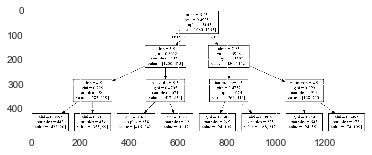

In [19]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_male, "male_decision_tree_sens.png", male_col_names, male_feature_names)

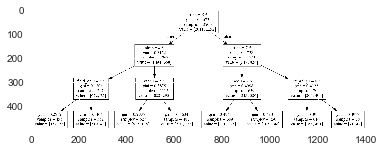

In [20]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_female, "female_decision_tree_sens.png", female_col_names, female_feature_names)

### <font color="green">Evaluating the performance of the gender models</font>

<font color="red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results. Please see consult our first assignment</i></b>

In [21]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

Accuracy score:  0.710858585859


In [22]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

Accuracy score:  0.715355805243


In [23]:
print(metrics.classification_report(male_y_test, pred_male))

             precision    recall  f1-score   support

          0       0.71      0.72      0.71       395
          1       0.71      0.71      0.71       397

avg / total       0.71      0.71      0.71       792



In [24]:
print('percentage "dec = 0" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 0].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 1].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the male data set:  51.18 %
percentage "dec = 1" in the male data set:  48.82 %


In [25]:
print(metrics.classification_report(female_y_test, pred_female))

             precision    recall  f1-score   support

          0       0.74      0.83      0.78       501
          1       0.65      0.52      0.58       300

avg / total       0.71      0.72      0.71       801



In [26]:
print('percentage "dec = 0" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 0].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 1].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the female data set:  62.74 %
percentage "dec = 1" in the female data set:  37.26 %


### <font color="green">Unisex model with sensitive attributes</font>

In [27]:
unisex = pd.read_csv("speed_dating_assignment.csv")

In [28]:
unisex_o = unisex.copy()
unisex_o = unisex_o.filter(items=['iid', 'age', 'race', 'goal'])
unisex_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
unisex_o = unisex_o.drop_duplicates()

unisex_new = pd.merge(unisex, unisex_o, on=['pid'], how = 'left')
unisex = unisex_new.copy()

In [29]:
unisex = unisex[['attr', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
unisex.age.fillna(unisex.age.median(), inplace = True)
unisex = unisex.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

In [30]:
unisex['age_diff'] = abs(unisex['age'] - unisex['age_o'])
unisex['race_equals'] = (unisex['race'] == unisex['race_partner'])
unisex['goal_equals'] = unisex.apply(lambda r: r.goal == r.goal_partner, axis = 1)
unisex = unisex[['order','goal', 'field_cd', 'date','age', 'go_out', 'attr', 'imprace', 'imprelig', 'race','age_diff', 'goal_equals', 'dec']]
unisex.head()

,order,goal,field_cd,date,age,go_out,attr,imprace,imprelig,race,age_diff,goal_equals,dec
0,4,2.0,1.0,7.0,21.0,1.0,6.0,2.0,4.0,4.0,6.0,False,1
1,3,2.0,1.0,7.0,21.0,1.0,7.0,2.0,4.0,4.0,1.0,False,1
2,10,2.0,1.0,7.0,21.0,1.0,5.0,2.0,4.0,4.0,1.0,True,1
3,5,2.0,1.0,7.0,21.0,1.0,7.0,2.0,4.0,4.0,2.0,True,1
4,7,2.0,1.0,7.0,21.0,1.0,5.0,2.0,4.0,4.0,3.0,False,1


In [31]:
# Training the model
subjects_shuff_uni = unisex.sample(frac=1).reset_index(drop=True) # shuffle rows
x_data_uni = subjects_shuff_uni.drop('dec', axis = 1) # dec is target attribute
labels_uni = subjects_shuff_uni['dec']

In [32]:
x_train_uni, x_test_uni, y_train_uni, y_test_uni = train_test_split(x_data_uni, labels_uni, test_size = 0.2)

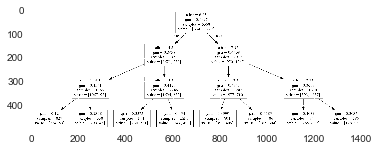

In [33]:
dec_tree_uni = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_uni.fit(x_train_uni, y_train_uni)
col_names_uni = dec_tree_uni.classes_
feature_names_uni = unisex.columns[0:(unisex.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_uni, "unisex_decision_tree_sens.png", col_names_uni, feature_names_uni)

In [34]:
pred_uni = dec_tree_uni.predict(x_test_uni) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(y_test_uni, pred_uni))

Accuracy score:  0.747018204645


In [35]:
print(metrics.classification_report(y_test_uni, pred_uni))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77       896
          1       0.70      0.73      0.72       697

avg / total       0.75      0.75      0.75      1593



In [36]:
print('percentage "dec = 0" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 0].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 1].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the unisex data set:  56.99 %
percentage "dec = 1" in the unisex data set:  43.01 %


## <font color="red">----------------------------------------------------------------------------------------------------</font>

## <font color="red">Start second homework assignment</font>

# Part 2: Discrimination-aware classification

#### <font color="darkred">The goal of this assignment is to acquire a deeper understanding of model performance and to study how one can compare performance of different models and their internals/decision logic</font>

#### Abdel K. Bokharouss - December 2017
## 1 Sensitive attributes in classification

### 1.1 Modeling without sensitive attributes

The predictive models of the first assignment can, for example, be used to match partcipants of a (speed) dating event. Some people might not like the idea of an algorithm matching them to other participants. Especially when this algorithm uses sensitive (<i>subjective</i>) attributes about them such as their race, their age (difference), how they value religion in their lives et cetera.

<br>The models which were trained in the first assignment (<b>see the two gender- and unisex model(s) at the start of this notebook</b>) did use some attributes that would be considered to be sensitive attributes. In particular, these models used the attributes <i>imprace</i>, <i>imprelig</i>, <i>race_equals</i>, <i>age_diff</i> and <i>race</i>.
The first two attributes tells something about how the subject values a partner who is of the same racial/religious background. The third attribute tells us whether the subject and potential match have the same racial background. The fourth attribute tells us about the age difference between the subject and the potential match. And the last attribute is the race of the subject. These are all considered to be sensitive attributes. It should come as no surprise why attributes related to the ethnicity and/or religious background are considered to be sensitive. Take for example the commotion last week around Facebook using the ethnicity of its users to target ads (https://www.technologyreview.com/the-download/609543/facebook-still-lets-people-target-ads-by-race-and-ethnicity/). The age difference is also considered to be a sensitive attribute since a lot of people would not like to be restricted to certain matches because of their age.

The first step of this task is, therefore, to build a predictive model that does not include these attributes.

In [37]:
attr_used_old = ['order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',
                 'imprelig', 'race','age_diff', 'attr', 'goal_equals', 'dec'] # old attributes used
sensitive_attr = ['imprace', 'imprelig', 'race_equals', 'age_diff', 'race', 'age'] # attributes which should be excluded
without_sens = [attribute for attribute in attr_used_old if attribute not in sensitive_attr]

In [38]:
uni_sens = unisex[without_sens] # use the same attributes, but exclude the sensitive attributes
print(uni_sens.shape)
uni_sens.head()

(7961, 8)


,order,goal,field_cd,date,go_out,attr,goal_equals,dec
0,4,2.0,1.0,7.0,1.0,6.0,False,1
1,3,2.0,1.0,7.0,1.0,7.0,False,1
2,10,2.0,1.0,7.0,1.0,5.0,True,1
3,5,2.0,1.0,7.0,1.0,7.0,True,1
4,7,2.0,1.0,7.0,1.0,5.0,False,1


In [39]:
uni_sens_shuff = uni_sens.sample(frac = 1).reset_index(drop = True) # shuffle the data
x_data_uni_sens = uni_sens_shuff.drop('dec', axis = 1) # dec is target attribute
labels_uni_sens = uni_sens_shuff['dec']

80/20 training-test split since this ratio was also used in the previous model

In [40]:
x_train_uni_sens, x_test_uni_sens, y_train_uni_sens, y_test_uni_sens = train_test_split(
    x_data_uni_sens, labels_uni_sens, test_size = 0.2)

The max-depth is set to 3 which will ease the comparative research between the model exploiting sensitive attributes and this model which is the same model, but excludes the sensitive attributes in the training and classification.

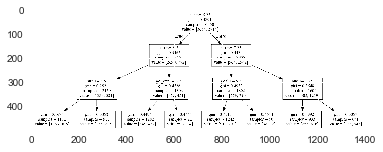

In [41]:
dec_tree_uni_sens = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_uni_sens.fit(x_train_uni_sens, y_train_uni_sens)
col_names_uni_sens = dec_tree_uni_sens.classes_
feature_names_uni_sens = uni_sens.columns[0:(uni_sens.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_uni_sens, "unisex_decision_tree_noSensAttr.png", col_names_uni_sens, feature_names_uni_sens)

In [42]:
pred_uni_sens = dec_tree_uni_sens.predict(x_test_uni_sens) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(y_test_uni_sens, pred_uni_sens))

Accuracy score:  0.740740740741


In [43]:
print(metrics.classification_report(y_test_uni_sens, pred_uni_sens))

             precision    recall  f1-score   support

          0       0.77      0.75      0.76       883
          1       0.70      0.72      0.71       710

avg / total       0.74      0.74      0.74      1593



#### <font color="green">Evaluating the performance of the (same) model which excludes the sensitive attributes</font>

A few cells back one can see that accuracy of the same unisex model <i>(0.747)</i> which uses the sensitive attributes is only slightly better than the accuracy of the same unisex model which exludes these attributes from the classification process. In the first assignment we have seen that the accuruacy is not the most appropriate performance metric, depending on the situation. The insignificant difference in accuracy does not validate a conclusion about the difference in performance between the two models. The next step is, therefore, to look at the other performance metrics. 

Even though the expectation there will be no major differences in precision and recall between the models, one can see that the recall of the model with the sensitive attributes for the cases in which the subject expressed an interest in his/her partner after the date (<i>dec = 1</i>) is higher than the recall of the same type of cases for the model excluding sensitive attributes, but this differenc of 0.01 is, ofcourse, not significant. The precision for this case remained the same after the exclusion of the sensitive attributes. The recall and precision metrics for the other potential value of the target attribute did also not undergo major devaluations. Both the recall and precision dropped by 0.01. One could, therefore, argue that the model got slightly worse at recognizing these cases (dec = 0) without the sensitive attributes, even though these differences are not substantial by any means. The slight drop in these performance metrics explains the slight decrease of the accuracy of the model which excludes the sensitive attributes.

#### <font color="green">Comparing the models in term of discrimination</font>

Several metrics which can be used to measure discrimination have been explained in a paper on the topic of discrimination/fairness-aware data mining (<a>link.springer.com/article/10.1007/s10618-017-0506-1</a>). The next step is to choose one or more of these discrimination measures to be able to quantify whether the model(s) discriminate, and if they do, how much to they disciminate.

Before diving into the actual discimination measures some notation needs to be introduced. Fair/non-discriminating data-minining can be defined as:
1. people that are similar in terms of non-protected charactersitics (i.e. non-sensitive atttributes) should receive similar predictions (i.e. classifications).
2. differences in predictions across groups of people can only be as large as justified by their non-protected (ie. non-sensitive attributes).

If this is translated to problem domain of matching subjects at a dating event the following conditions should hold in the context of fair/non-discriminating data-mining in predicitve models exploited at these events:

1. subjects that have similiar non-sensitive attributes (all the attributes used in the model, excluding the attributes which were classified earlier on as sensitive) should receive similar predictions.
2. differences in predictions across groups of subjects can only be as large as justified by their non-sensitive attributes.

The first condition is necessary, but not suffcient by itself to ensure non-discrimination/fairness in the predictive models. This can be explained by the fact that even though subjects who are similar (as far as the non-sensitve attributes can tell) are treated similary (receive similar predictions), groups of subjects with similarities in the non-sensitive attributes may be treated differently from other groups of subjects. 

Now let's get into the actual discrimination measures. The variable $y$ is used to denote the value of a binary target variable, $y \in \{y^+, y^-\}$ ($+$ (1) and $-$ (0) are used to denote the potential values of the binary target attribute).

The variable $s$ will be used to denote a protected attribute (i.e. a sensitive attribute) and $s^i$ will be used to denote value of categorical/binary protected attribute (i.e. a sensitive attribute). Index 1 will be used to denote the protected group in the context of this variable (e.g. $s^1$ will be used to denote a potential ethinic minority, and $s^0$ the majority).

The following probabilities notations are going to be used: $p(s^1)$ for $p(s = 1)$ and $p(y^+)$ for $p(y = +)$

Various discrimination measure types are given in the paper (e.g staticitcal tests, absolute-, conditional-, and situation-measures). Not all of these types are going to be considered in this discrimination analysis ( $\geq 1$ measure has to be assessed). The focus is going to be on absolute measures.

Absoulute measures measure the magnitude of discrimination (and thus also the presence/absence of discrimination). The groups are described by a certain characteristic protected attribute. In other words, the groups are divided by a certain sensitive attribute. This can be done with two groups (e.g. if gender would be considered to be a sensitive attribute; males and females), but also with more than one group (e.g. ethnicities). In the latter case one typically compares all the groups  to the most favoured group.

An absolute measure of discriminiation is the <b>mean difference</b> $d$. It is given by: $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1)$. If there is no difference, then it is considered that there is no discrimination. Note that there is, however, no correction for the standard deviation.

The most obvious sensitive attribute which is considered in this analysis to which this absolute measure can be applied is the <i>race</i> attribute. The ethnicities found in the test split of the unisex model which uses the sensitive attributes (and thus the race attribute) are:

In [44]:
unisex.race.unique()

array([ 4.,  2.,  6.,  3.,  1.])

The speed-dating datasets uses numerical encodings to distinguish the different races
* 1 = Black/African American
* 2 = European/Caucasian-American
* 3 = Latino/Hispanic American
* 4 = Asian/Pacific Islander/Asian-American
* <font color="lightgrey">(5 = Native America) </font> 
* 6 = Other

Let consider the mean of the binary target attribute of each of these ethnic groups (in the test sample)

In [45]:
race_encodings = {"Black/African American": 1, "European/Caucasian-American": 2, "Latino/Hispanic American": 3, 
                   "Asian/Pacific Islander/Asian-American": 4, "Other": 6}

The test sample can be found under the variable $x\_test\_uni$. This dataframe does not have a column with the actual predictions for those records. The actual predictions can be found under the variable $pred\_uni$. These two need to be linked before the mean of the binary target attribute of each of the ethnic groups can be calculated.

In [46]:
x_data_test = x_test_uni.copy()
x_data_test["pred_dec"] = pred_uni # assign the prediction to the original test records
x_data_test.head() 

,order,goal,field_cd,date,age,go_out,attr,imprace,imprelig,race,age_diff,goal_equals,pred_dec
3108,5,2.0,13.0,6.0,29.0,3.0,5.0,2.0,7.0,2.0,1.0,False,0
4691,7,1.0,3.0,6.0,27.0,3.0,4.0,3.0,5.0,2.0,1.0,True,0
3591,3,5.0,5.0,5.0,22.0,3.0,4.0,6.0,6.0,2.0,6.0,False,0
6782,5,3.0,1.0,6.0,24.0,1.0,7.0,1.0,3.0,4.0,3.0,False,1
7732,1,1.0,3.0,4.0,33.0,2.0,7.0,1.0,7.0,2.0,6.0,False,1


In [47]:
for k, v in race_encodings.items():
    print("The mean of the target attribute of the", k, "group is", x_data_test.loc[x_data_test.race == v].pred_dec.mean())

The mean of the target attribute of the Black/African American group is 0.5052631578947369
The mean of the target attribute of the European/Caucasian-American group is 0.4638009049773756
The mean of the target attribute of the Latino/Hispanic American group is 0.43333333333333335
The mean of the target attribute of the Asian/Pacific Islander/Asian-American group is 0.40934065934065933
The mean of the target attribute of the Other group is 0.52


One can immediately conclude that the model which uses the sensitive attributes ($race$ in particular) is not an example of fair/non-discriminating data-minining/predictive modeling. The magnititude of discrimination for all the groups can be calculated by $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1)$, where one uses the ethnic minority as $s^1$, which is in this case the Asian/Pacific Islander/Asian-American group, and where $s^0$ would be the majority. Calculating the magnitude of discrimination for the Asian/Pacific Islander/Asian-American would result in $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1) = E(y^+\,|\, s^0) - 0.40934.$

Note, however, that the absolute measure mean difference should actually be used for binary protected variables. The mean difference should thus be defined as the mean targets of the protected group and the general group. This means that one ethnic group should be classified as the protected group, while all the other ethnic groups (i.e. races) are defined to be the general group in this problem's context  This immediately brings us to the next question: based on the results depicted above, what group should be classfied as the protected group and the general group? This can be a tricky question since it depends on the context of the problem and the perspective of the problem-solver. Firs note that discrimination by a predictive model can only occur when the target bariable is polar. In the paper on discrimination measures a classical and straightforward example is given. The paper discusses the problem of loan-granting. It is quite clear that getting a loan (for which is applied by the applicant) is better than receiving no loan, when this decision making is done or supported by an algorithm (predictive model). It is thus quite clear that a protected group which is shown to receive less often loans than a similar group with the same attributes, except the sensitive attributes. But in the context of speed-dating one could argue both ways. One could say that an algorithm which matches the subject less often is better than when it matches the subject more often (i.e. the mean of the target-attribute <i>dec</i> is lower) since this would mean that the subject has to go on less dates with potential partners (more effective), if this model to match subjects before actually sending them out on dates. But one could also argue that a match prediction outcome (dec = 1) is more superior than to others (dec = 0). The choice is made to chose tha latter since the assumption is made that subjects would probably rather go on more dates and increase their chances of finding a partner. This, thus means, a lower mean of the target attribute would considered to be unfavorable compared to a higher mean of the target attribute.

This would thus imply that the Asian/Pacific Islander/Asian-American group is the ethnic minority in this context and that the absolute mean of the majority (general group) would be the mean of all the ethnic groups other than Asian/Pacific Islander/Asian-American group. 

In [48]:
print("The mean of the target attribute of the majority (general group) = ",
      x_data_test.loc[x_data_test.race != race_encodings.get("Asian/Pacific Islander/Asian-American")].pred_dec.mean())

The mean of the target attribute of the majority (general group) =  0.467860048820179


The magnitude of discrimination for the Asian/Pacific Islander/Asian-American would thus result in $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1) = 0.46786 - 0.40934 = 0.05852 $

From this calculation one can safely conclude the presence of discrimination of the predictive model at a dataset level. In addition, the magnitude of this discrimination for the ethnic minortity which is the Asian/Pacific Islander/Asian-American is captured. Note how close the mean of the target attribute of the European/Caucasian-American group is to the mean of the of the target attribute of the majority (general group) (even though the European/Caucasian-American subjects are also used in the calculation of the man of the majority). One would expect that this group would be the least prone to discrimination at a speed-dating event in the United States, as one can conclude from these measures. It is, however, not safe to reason about any causation of the resulting measure, considering the small sample size and relative general and instable model.

Another absolute measure which is going to be considered (extra; one discrimination meausure is ought to be sufficient according to the assignment description) is the normalized difference. The normalized difference is fairly similar to the absolute mean difference, except as one would expect from the name of the measure; the mean difference is normalized by the rate of the positive outcomes. This can be captured by the following formular (where $\delta$ denotes the normalized mean difference):

$\delta = \frac{p\left(y^+\,|\, s^0\right) - p\left(y^+\,|\,s^1\right)}{d_{max}}$, $\, \,$where $\, d_{max} = min\,\left(\left(\frac{ p(y^+)}{p(s^1)}\right),\left(\frac{p(y^-)}{p(s^0)}\right)\right)$

Now let's calculate $d_{max}$ first.

In [49]:
p_y_plus = len(x_data_test[x_data_test.pred_dec == 1]) / len(x_data_test)
p_y_min = len(x_data_test[x_data_test.pred_dec == 0]) / len(x_data_test) # can also use 1 - p_y_plus
"p_y_plus: ", p_y_plus, "p_y_min: ", p_y_min, (p_y_plus +  p_y_min == 1)

('p_y_plus: ', 0.45448838669177655, 'p_y_min: ', 0.5455116133082235, True)

In [50]:
p_s_one = p_y_plus = len(x_data_test[x_data_test.race == 
                                     race_encodings.get("Asian/Pacific Islander/Asian-American")]) / len(x_data_test)
p_s_zero = len(x_data_test[x_data_test.race
                           != race_encodings.get("Asian/Pacific Islander/Asian-American")]) / len(x_data_test)
"p_s_one: ", p_s_one, "p_s_zero: ", p_s_zero, (p_s_one +  p_s_zero == 1)

('p_s_one: ', 0.22849968612680477, 'p_s_zero: ', 0.7715003138731952, True)

In [51]:
d_max = min((p_y_plus / p_s_one), (p_y_min / p_s_zero))
d_max

0.7070789259560619

In [52]:
numerator = (x_data_test.loc[x_data_test.race != race_encodings.get(
    "Asian/Pacific Islander/Asian-American")].pred_dec.mean()) - (x_data_test.loc[x_data_test.race == race_encodings.get(
    "Asian/Pacific Islander/Asian-American")].pred_dec.mean())
numerator

0.05851938947951968

In [53]:
normalized_difference = (numerator) / d_max
normalized_difference

0.08276217453432644

This measure takes into account maximum possible discrimination at a given positive outcome rate, such that the magnitude of discrimiantion is at most $\delta = 1$ (maximum possible discrimination), while $\delta = 0$ indicates that the absence of discrimination, as explained in the paper on measuring discrimination in algorithmic decision making. From these results one  can make the conclusion that there is indeed presence of some discrimination in the predictive model on data set level, but the discrimination is far from extreme. Note in addition, that more protected attributes (i.e. sensitive attributes) can be evaluated to get more complete assesment of discrimination in the model.

### 1.2 Qualitative Comparison

Two unisex models have been considered in part 1.1. One model that includes-, and one model that excludes these same- sensitive attributes. The performance differences, absence/presence of discrimination and magnitude of discrimination have been assessed and evaluated. The next step is to look for differences in behaviour (i.e. decision) logic between the two models.

This comparison is going to start with a comparison of the visualizations which capture the decision logic of the two models that correspondingly include and exclude the sensitive attributes.

These two walks in the decision trees are a clear difference in decision logic of the two models:

* $(attr \leq 6.25) \,\rightarrow\, (attr > 5.5)\, \rightarrow\, (go\_out > 5.5)$ $\rightarrow$ ($dec = 1$) for the model which excludes sensitive attributes.
* $(attr \leq 6.25) \,\rightarrow\, (attr > 4.5)\, \rightarrow\, (attr > 5.5)$ $\rightarrow$ (i.e. $dec = 0$) for the model which includes sensitive attributes.

Let's have a look whether the predictions for the test sample are confirming to this analysis of the differences in the decision logic.

In [54]:
x_data_nosens_test = x_test_uni_sens.copy()
x_data_nosens_test["pred_dec"] = pred_uni_sens  # assign the prediction to the original test records
x_data_nosens_test.head()

,order,goal,field_cd,date,go_out,attr,goal_equals,pred_dec
7055,7,6.0,9.0,4.0,3.0,6.0,True,0
267,16,1.0,1.0,4.0,1.0,4.0,False,0
5562,2,6.0,8.0,4.0,2.0,4.0,False,0
2417,2,2.0,13.0,6.0,3.0,8.0,False,1
2896,14,2.0,9.0,5.0,3.0,7.0,False,1


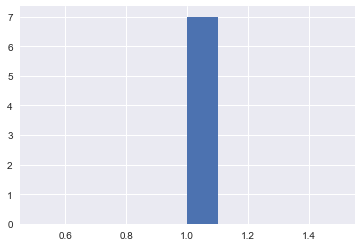

In [55]:
x_data_nosens_test[(x_data_nosens_test.attr <= 6.25) & (x_data_nosens_test.attr > 5.5) & (x_data_nosens_test.go_out > 5.5)].pred_dec.hist()

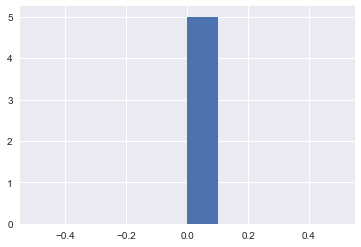

In [56]:
x_data_test[(x_data_test.attr <= 6.25) & (x_data_test.attr > 5.5) & (x_data_test.go_out > 5.5)].pred_dec.hist()

And indeed, the decision logic of the two models that correspondingly include and exclude the sensitive attributes results in conflicting predictions for these samples.

## 2 Patterns of discrimination

### 2.1 Is there still a bias towards gender?

In [57]:
df_new = pd.read_csv("speed_dating_assignment.csv")
df_new = df_new.drop_duplicates(subset='iid')

df_new.shape

(551, 175)

In [58]:
df_goal_male = df_new[df_new['gender'] == 1]
grouped_goal_male = df_goal_male.groupby(['goal']).size()
grouped_goal_male

goal
1.0    113
2.0     89
3.0     27
4.0     13
5.0     17
6.0     16
dtype: int64

In [59]:
df_goal_female = df_new[df_new['gender'] == 0]
grouped_goal_female = df_goal_female.groupby(['goal']).size()
grouped_goal_female

goal
1.0    115
2.0    100
3.0     13
4.0      9
5.0     18
6.0     14
dtype: int64

In [60]:
df_field_male = df_new[df_new['gender'] == 1]
grouped_field_male = df_field_male.groupby(['field_cd']).size()
grouped_field_male

field_cd
1.0      28
2.0       9
3.0      10
4.0       2
5.0      43
6.0       5
7.0       9
8.0     100
9.0       5
10.0     30
11.0      1
12.0      1
13.0     21
14.0      4
15.0      2
16.0      1
17.0      1
18.0      2
dtype: int64

In [61]:
df_field_fe = df_new[df_new['gender'] == 0]
grouped_field_fe = df_field_fe.groupby(['field_cd']).size()
grouped_field_fe

field_cd
1.0     20
2.0      5
3.0     36
4.0      7
5.0     13
6.0     16
7.0      8
8.0     30
9.0     35
10.0    31
11.0    29
13.0    25
14.0     3
15.0     9
16.0     2
18.0     1
dtype: int64

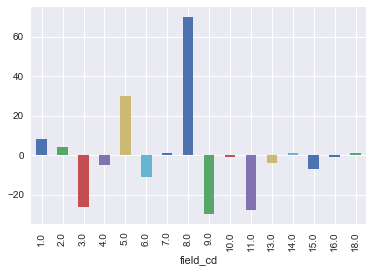

In [62]:
grouped_field_diff = df_field_male.groupby(['field_cd']).size() - df_field_fe.groupby(['field_cd']).size()
grouped_field_diff= grouped_field_diff.dropna()
grouped_field_diff.plot(kind= 'bar')

In [63]:
discrimination = dates.copy()

In [64]:
discrimination = discrimination.drop(['order', 'goal', 'date', 'age', 'go_out', 'age_diff', 'goal_equals', 'dec'], axis=1)
discrimination.head()

,gender,field_cd,imprace,imprelig,attr,race
0,0,1.0,2.0,4.0,6.0,4.0
1,0,1.0,2.0,4.0,7.0,4.0
2,0,1.0,2.0,4.0,5.0,4.0
3,0,1.0,2.0,4.0,7.0,4.0
4,0,1.0,2.0,4.0,5.0,4.0


In [65]:
discrimination.corr(method='spearman')

,gender,field_cd,imprace,imprelig,attr,race
gender,1.000000,-0.111995,-0.121293,-0.215192,0.126472,-0.031612
field_cd,-0.111995,1.000000,0.002367,-0.054167,-0.024461,0.020389
imprace,-0.121293,0.002367,1.000000,0.467423,-0.043666,-0.127275
imprelig,-0.215192,-0.054167,0.467423,1.000000,-0.038745,-0.086100
attr,0.126472,-0.024461,-0.043666,-0.038745,1.000000,-0.041984
race,-0.031612,0.020389,-0.127275,-0.086100,-0.041984,1.000000


In [66]:
cross = pd.crosstab(discrimination["field_cd"], discrimination["gender"])
print(cross)

gender      0     1
field_cd           
1.0       274   366
2.0        82   123
3.0       479   165
4.0       113    27
5.0       185   621
6.0       261    53
7.0       133   107
8.0       414  1407
9.0       528    73
10.0      478   507
11.0      443    18
12.0        0    18
13.0      370   319
14.0       55    69
15.0      145    29
16.0       29     9
17.0        0    10
18.0       15    36


###### Unisex decision tree
![title](unisex_decision_tree_sens.png)

###### Male decision tree
![title](male_decision_tree_sens.png)

###### Female decision tree
![title](female_decision_tree_sens.png)

Now, here is a colour-coded version of the unisex decision tree. Decisions that are more similar to the female model than they are to the male model have been coloured pink. Likewise, seemingly male-oriented decisions have been coloured blue. Decisions that are average between the male and female models were coloured orange, and finally, decisions that appear in neither the male, nor the female model have been left white.
![title](unisex_decision_tree_sens_coloured.png)

As you can see, the first step in the decision tree is a perfect average of the male and female models, which only makes sense. The decisions in the second level, however, are closer to those in the male model. The decisions in the female model are similar as well, but the values used in the unisex model are slightly closer to those that appear in the male model. Finally, we can see that in the third level, the decisions are clearly more similar to those in the female model. None of the decisions in this level look anything like those in the male model. This level also has one decision that has been coloured white, meaning it wasn't similar to either of the gender models.

But even though these decisions look like they come from the female model, we do not really know whether they hold for males as well.

To find out whether these decisions really are gender-oriented, we will take as example the bottom-right decision based on 'imprace <= 7.5'. If the female subjects are the only ones for whom this step in the decision tree has the approprate effect on their values of 'dec', then this will show that it is indeed a female-oriented decision. However, if the dec-values for males are affected similarly, then this would show that the model doesn't discriminate, and that this decision makes sense for both genders.

In [67]:
male_subjects0 = male_subjects.drop(male_subjects[male_subjects.attr_o <= 44.25].index)
male_subjects1 = male_subjects0.drop(male_subjects0[male_subjects0.imprace > 7.5].index)
male_subjects2 = male_subjects0.drop(male_subjects0[male_subjects0.imprace <= 7.5].index)

AttributeError: 'DataFrame' object has no attribute 'attr_o'

In [ ]:
male_subjects11 = male_subjects1.drop(male_subjects1[male_subjects1.dec == 0].index)
male_subjects12 = male_subjects1.drop(male_subjects1[male_subjects1.dec == 1].index)
print("Male percentage dec=1 where imprace=<7.5 : " + str(len(male_subjects11) / (len(male_subjects12) + len(male_subjects11))))

In [ ]:
male_subjects21 = male_subjects2.drop(male_subjects2[male_subjects2.dec == 0].index)
male_subjects22 = male_subjects2.drop(male_subjects2[male_subjects2.dec == 1].index)
print("Male percentage dec=1 where imprace>7.5: " + str(len(male_subjects21) / (len(male_subjects22) + len(male_subjects21))))

In [ ]:
female_subjects0 = female_subjects.drop(female_subjects[female_subjects.attr_o <= 44.25].index)
female_subjects1 = female_subjects0.drop(female_subjects0[female_subjects0.imprace > 7.5].index)
female_subjects2 = female_subjects0.drop(female_subjects0[female_subjects0.imprace <= 7.5].index)

In [ ]:
female_subjects11 = female_subjects1.drop(female_subjects1[female_subjects1.dec == 0].index)
female_subjects12 = female_subjects1.drop(female_subjects1[female_subjects1.dec == 1].index)
print("Female percentage dec=1 where imprace=<7.5 : " + str(len(female_subjects11) / (len(female_subjects12) + len(female_subjects11))))

In [ ]:
female_subjects21 = female_subjects2.drop(female_subjects2[female_subjects2.dec == 0].index)
female_subjects22 = female_subjects2.drop(female_subjects2[female_subjects2.dec == 1].index)
print("Female percentage dec=1 where imprace>7.5: " + str(len(female_subjects21) / (len(female_subjects22) + len(female_subjects21))))

As these numbers show, it is not only the female decisions that have an increased chance when imprace <= 7.5. In fact, for males the increase in positive decisions is even greater (from 56% to 79%, instead of 54% to 72%). This shows that the decision is not female-oriented, and thus that the model doesn't discriminate.

This raises the following question though: why wasn't this decision in the male model?

### 2.2 Biclustering